In this notebook, I have implemented multiclass classification using a neural network.

1. Number of hidden layers = 2
2. Number of nodes in each layer:
    - input layer: 2
    - first hidden layer: 5
    - second hidden layer: 5
    - output layer: 3
3. Activation functions:
    - hidden layers: tanh
    - output layer: softmax
4. Number of epochs: 1000
5. Optimizer: Stochastic Gradient Descent
6. Learning rate: 0.001

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('train3class.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,x1,x2,label
0,2.68282,3.04190,1.0
1,-9.40585,2.37006,2.0
2,5.23510,-0.25123,1.0
3,-0.16270,2.60706,1.0
4,11.16277,-11.61693,0.0


Let us check the classes in the dataset, and how many examples belong to each class

In [3]:
df['label'].value_counts()

0.0    151
2.0    150
1.0    150
Name: label, dtype: int64

Split the data into training and test sets: 80% training, 20% test

In [4]:
X = np.array(df[['x1', 'x2']])
y = np.array(df['label'])

X_train = X[:int(df.shape[0]*0.8), :]
X_test = X[int(df.shape[0]*0.8):, :]
y_train = y[:int(df.shape[0]*0.8)]
y_test = y[int(df.shape[0]*0.8):]

# Convert the training labels into one-hot vectors.
temp = np.zeros((y_train.shape[0], 3))
for i in range(len(temp)):
    temp[i][int(y_train[i])] = 1
y_train_one_hot = temp

temp1 = np.zeros((y_test.shape[0], 3))
for i in range(len(temp1)):
    temp1[i][int(y_test[i])] = 1
y_test_one_hot = temp1

### No. of nodes in the Input and Output Layers

In [5]:
input_nodes = X_train.shape[1]
output_nodes = y_train_one_hot.shape[1]

### Activation functions and their Derivatives

In [6]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    # x is the tanh value
    return (1 - (np.tanh(x)**2))

def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def softmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

### Loss function and its derivative

In [7]:
def crossentropyloss(y, y_hat):
    """Categorical cross-entropy loss for multiclass classification"""
    return -np.sum(y.reshape(y_hat.shape) * np.log(y_hat))

def crossentropyloss_derivative(y, y_hat):
    """Derivative of the cross entropy loss"""
    return -np.divide(y, y_hat)

### Initialization

In [8]:
def initialize_parameters(layer_dims):
    np.random.seed(42)
    parameters = {}
    for i in range(1, len(layer_dims)):
        W = np.random.rand(layer_dims[i], layer_dims[i-1])*0.01
        b = np.zeros((layer_dims[i], 1))
        parameters["W"+str(i)] = W
        parameters["b"+str(i)] = b
    
    return parameters

### Forward Propagation

In [9]:
def forward_propagation(X, parameters):
    L = len(layer_dims)
    A = [None]*L
    Z = [None]*L
    A[0] = X.reshape((2, 1))
    
    for l in range(1, L):
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        Z[l] = np.dot(W, A[l-1]) + b
        if l == L-1:
            A[l] = softmax(Z[l])
        else:
            A[l] = tanh(Z[l])
            
    output = A[L-1]
            
    return output, A, Z 

### Backpropagation

In [10]:
def backprop(y_hat, y, A, Z, parameters):
    gradients = {}
    L = len(layer_dims) - 1
    y = y.reshape(y_hat.shape)
    dWL = np.dot((y_hat - y), A[L-1].T)
    dbL = y_hat - y
    dZL = y_hat - y
    dAL = -np.divide(y, y_hat)
    
    gradients["dA"+str(L)] = dAL
    gradients["dW"+str(L)] = dWL
    gradients["db"+str(L)] = dbL
    gradients["dZ"+str(L)] = dZL
    
    for l in reversed(range(1, L)):
        gradients["dA"+str(l)] = np.dot(parameters["W"+str(l+1)].T, gradients["dZ"+str(l+1)])
        gradients["dZ"+str(l)] = gradients["dA"+str(l)] * tanh_derivative(Z[l])
        gradients["dW"+str(l)] = np.dot(gradients["dZ"+str(l)], A[l-1].T)
        gradients["db"+str(l)] = gradients["dZ"+str(l)]
        
    return gradients

### Parameter Update

In [11]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

### Plotting cost curve

In [12]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training Loss vs Number of Epochs", size=18)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

### Building the Model

In [13]:
def NN_model(X_train, y_train, X_test, y_test, layer_dims, learning_rate=0.001, max_epochs=500):
    parameters = initialize_parameters(layer_dims)
    
    epoch_cost = [] # average training cost at the end of every epoch
    
    prev_epoch_cost = 1000 # some large initial value
    curr_epoch_cost = 0
    
    validation_epoch_cost = [] # average validation cost at the end of every epoch
    
    count=1 # keeps track of the number of epochs
    # An epoch is one complete pass through the training data
    
    while abs(prev_epoch_cost-curr_epoch_cost) > 1e-7 and count<=max_epochs:
        costs = []# training costs
        val_costs = []# validation costs
        count+=1# increment the number of epochs
        for i in range(len(X_train)):
            output, A, Z = forward_propagation(X_train[i], parameters)
            cost = crossentropyloss(y_train[i], output)
            gradients = backprop(output, y_train[i], A, Z, parameters)
            parameters = update_parameters(parameters, gradients, learning_rate)
            costs.append(cost)
            
        # vaidation part (these examples do not contribute to parameter update)
        # therefore, the 'model' has still not seen these examples.
        for j in range(len(X_test)):
            out, _, _ = forward_propagation(X_test[j], parameters)
            cost = crossentropyloss(y_test[j], out)
            val_costs.append(cost)
            
        # average training loss for one epoch
        curr_epoch_cost = sum(costs)/len(X_train)
        if len(epoch_cost) >= 1:
            prev_epoch_cost = epoch_cost[-1]
        epoch_cost.append(curr_epoch_cost)
        
        # average validation loss for one epoch
        validation_epoch_cost.append(sum(val_costs)/len(X_test))
        
    plot_cost_curve(epoch_cost, validation_epoch_cost)
    return parameters, epoch_cost

### Predictions and Accuracy

In [14]:
def predict(X, parameters):
    # X here is one training example
    pred, _, _ = forward_propagation(X, parameters)
    return pred

def predictions(X, parameters):
    # X is an array of many training examples
    y_pred = np.zeros(len(X))
    for i in range(len(X)):
        y_pred[i] = np.argmax(predict(X[i], parameters))
    return y_pred
        
def model_accuracy(predictions, y_truth):
    return np.mean(predictions == y_truth)*100

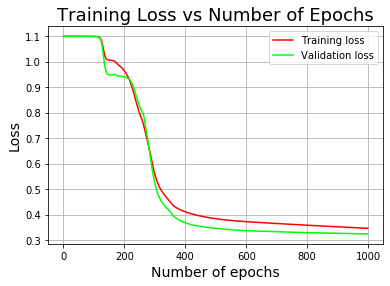

In [15]:
layer_dims = [input_nodes, 5, 5, output_nodes]
parameters, epoch_cost = NN_model(X_train, y_train_one_hot, X_test, y_test_one_hot, layer_dims, learning_rate=0.001, max_epochs=1000)

In [16]:
y_pred_train = predictions(X_train, parameters)
print("Training accuracy = {}%".format(round(model_accuracy(y_pred_train,y_train), 3)))

y_pred_test = predictions(X_test, parameters)
print("Test accuracy = {}%".format(round(model_accuracy(y_pred_test, y_test), 3)))

Training accuracy = 87.5%
Test accuracy = 89.011%
